-RECONEIXEMENT DE IMATGES DEFINITIU-

Ara que ja he provat que funciona el programa de classificació de imatges de flors, m'inspiraré en el tutorial per el meu propi programa de classificació de residuus domèstics.

Cal instal·lar l'última versió de tf

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
data_dir=pathlib.Path("./Reconeixement de Imatges")

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

185


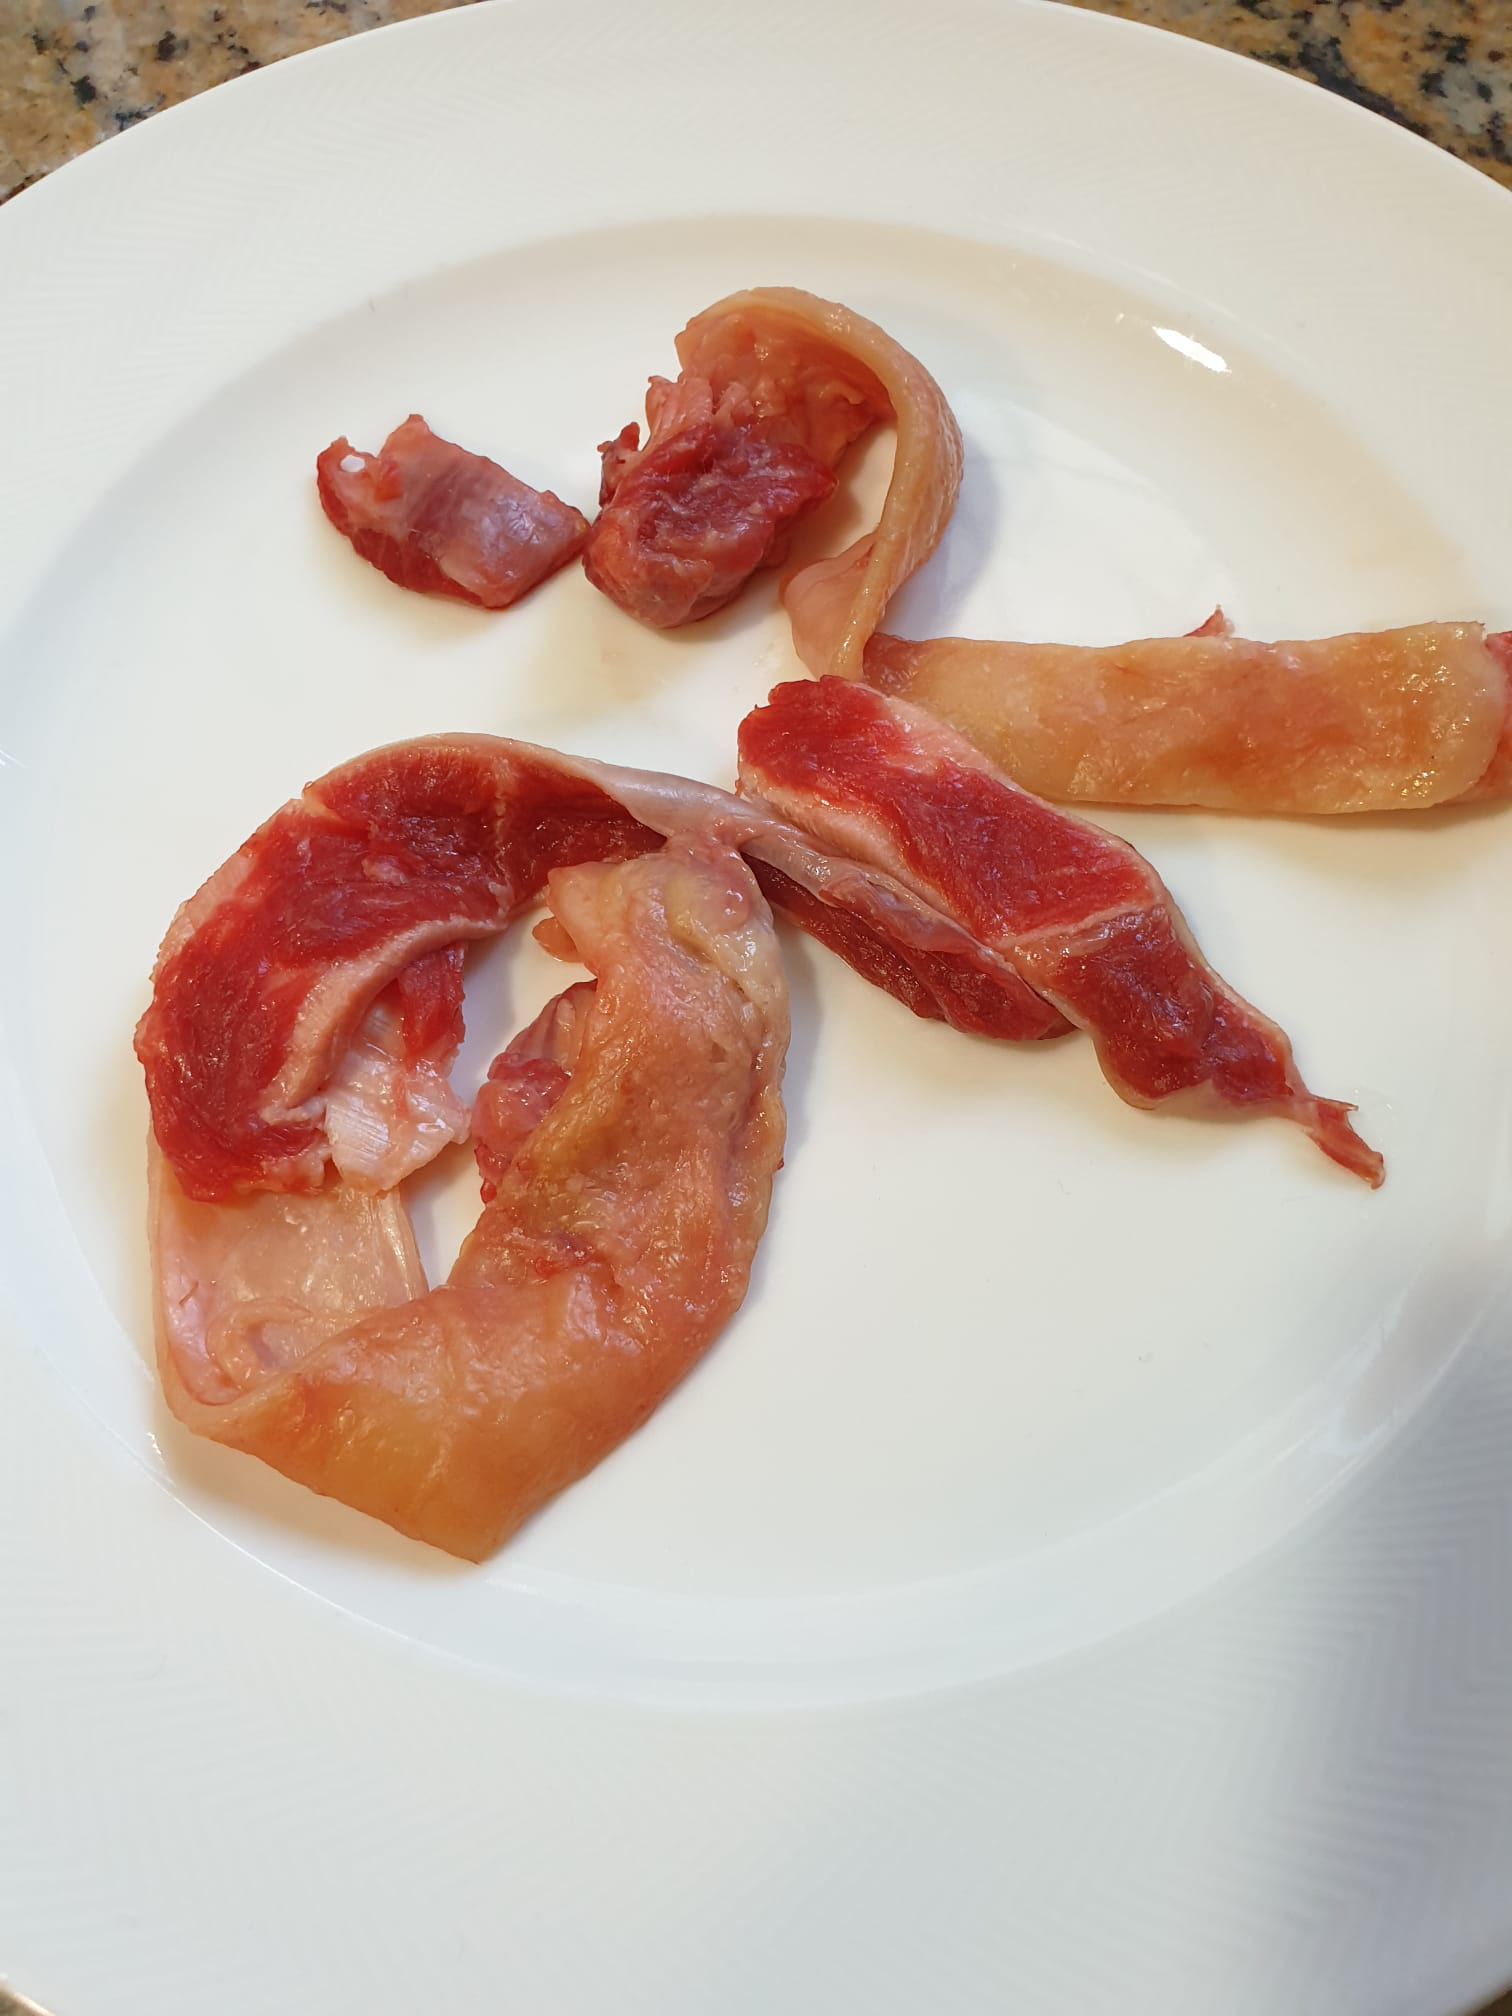

In [5]:
Organic = list(data_dir.glob('Organic/*'))
PIL.Image.open(str(Organic[0]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 208 files belonging to 5 classes.
Using 167 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 208 files belonging to 5 classes.
Using 41 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Envasos', 'Organic', 'Paper', 'Rebuig', 'Vidre']


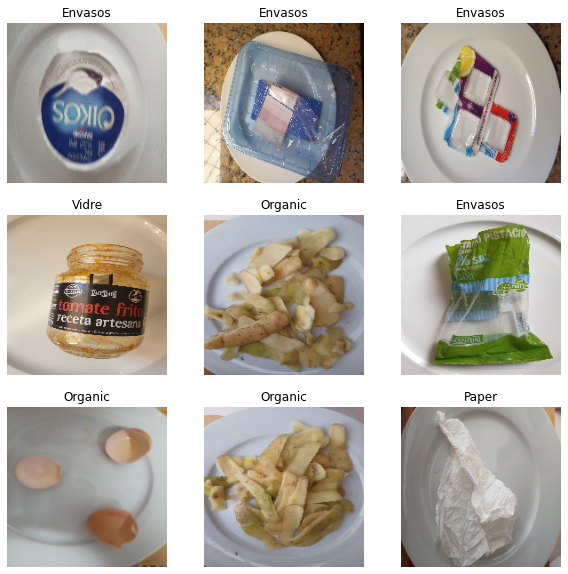

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.015686275 1.0


In [15]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
6/6 [==============================] - 3s 523ms/step - loss: 1.6367 - accuracy: 0.2695 - val_loss: 1.4771 - val_accuracy: 0.2927
Epoch 2/10
6/6 [==============================] - 1s 176ms/step - loss: 1.2294 - accuracy: 0.4611 - val_loss: 1.1625 - val_accuracy: 0.5366
Epoch 3/10
6/6 [==============================] - 1s 151ms/step - loss: 1.0767 - accuracy: 0.5269 - val_loss: 1.2369 - val_accuracy: 0.5854
Epoch 4/10
6/6 [==============================] - 1s 152ms/step - loss: 0.9691 - accuracy: 0.5509 - val_loss: 1.0164 - val_accuracy: 0.6341
Epoch 5/10
6/6 [==============================] - 1s 176ms/step - loss: 0.8497 - accuracy: 0.6347 - val_loss: 0.9859 - val_accuracy: 0.7561
Epoch 6/10
6/6 [==============================] - 1s 152ms/step - loss: 0.6888 - accuracy: 0.7665 - val_loss: 0.9977 - val_accuracy: 0.6098
Epoch 7/10
6/6 [==============================] - 1s 148ms/step - loss: 0.5820 - accuracy: 0.8084 - val_loss: 0.8804 - val_accuracy: 0.7561
Epoch 8/10
6/6 [====

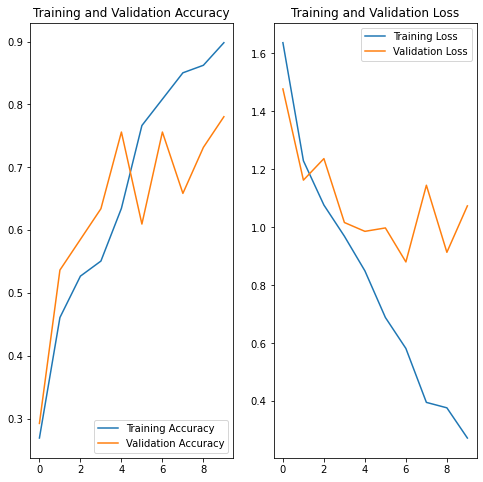

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

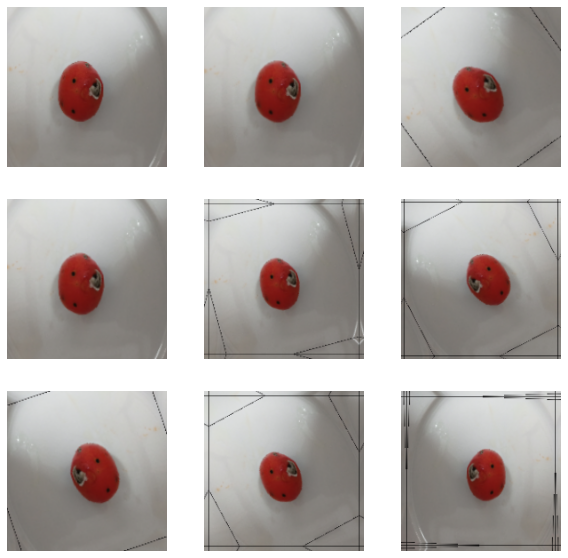

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [27]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
6/6 [==============================] - 1s 165ms/step - loss: 1.0034 - accuracy: 0.5689 - val_loss: 0.9915 - val_accuracy: 0.7073
Epoch 2/10
6/6 [==============================] - 1s 192ms/step - loss: 0.9280 - accuracy: 0.5868 - val_loss: 0.9839 - val_accuracy: 0.5366
Epoch 3/10
6/6 [==============================] - 1s 164ms/step - loss: 0.8715 - accuracy: 0.6228 - val_loss: 0.8812 - val_accuracy: 0.6585
Epoch 4/10
6/6 [==============================] - 1s 165ms/step - loss: 0.8323 - accuracy: 0.6287 - val_loss: 0.8163 - val_accuracy: 0.6829
Epoch 5/10
6/6 [==============================] - 1s 165ms/step - loss: 0.7937 - accuracy: 0.6527 - val_loss: 0.7788 - val_accuracy: 0.7073
Epoch 6/10
6/6 [==============================] - 1s 190ms/step - loss: 0.7343 - accuracy: 0.6587 - val_loss: 1.0602 - val_accuracy: 0.5854
Epoch 7/10
6/6 [==============================] - 1s 190ms/step - loss: 0.7203 - accuracy: 0.6707 - val_loss: 0.7527 - val_accuracy: 0.7561
Epoch 8/10
6/6 [====

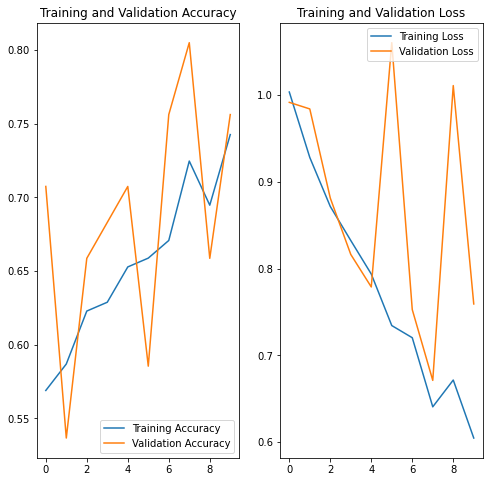

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Com classificar una imatge?

In [29]:
img = keras.preprocessing.image.load_img(
    "Reconeixement de Imatges/Organic/IMG-20200906-WA0037.jpg", target_size=(img_height, img_width)
)

In [30]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch



In [31]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Organic with a 90.36 percent confidence.
